### Import data

In [1]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

param_lap_dde = CSV.read(joinpath("..", "data", "params_lap_DDE.csv"))
conc = [param_lap_dde[8,col] for col in 2:9]

# import G1, G2, and population data
pop, g2, g1, g2_0, g1_0 = get_data(joinpath("..", "data", "lap.csv"),
                                   joinpath("..", "data", "lap_pop.csv"));
# removing peaks from the data
for i in 1:length(conc)
    pop[:, i] = remove_peaks(pop[:, i])
    g2[:, i] = remove_peaks(g2[:, i])
    g1[:, i] = remove_peaks(g1[:, i])
end

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:30
└ @ Main /home/farnazm/dde/improve_fit/DrugResponseModel.jl/src/importData.jl:30
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[1]:13
└ @ Core ./In[1]:13


### Hill model, residual functions and optimization

In [2]:
#  [EC50, b_steepness, alpha_min, alpha_max, beta_min, beta_max, tau1_mean, tau1_max, tau2_min, tau2_max, gamma1_max, gamma2_max]
# lower bound
low = [30.0, 0.01, 0.006, 0.001, 0.02, 0.04, 6.0, 30.0, 8.0, 6.0, 0.0004, 0.03]
# upper bound
high = [250.0, 10.0, 0.008, 0.03, 0.08, 0.05, 10.0, 40.0, 15.0, 10.0, 0.003, 0.05]
# guess
guess = [100.0, 1.0 , 0.007, 0.01, 0.05, 0.045, 8.0286, 30.1100, 12.0, 8.0, 0.0035, 0.04]
# max num of steps
num_steps=50
parameterrs, pp = optimize_hill(guess, conc, g1, g2, g1_0, g2_0, low, high, num_steps)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 51 steps and 11.17 seconds
Termination reason: Max number of steps (50) reached
Steps per second = 4.57
Function evals per second = 7.43
Improvements/step = 0.58000
Total function evaluations = 83


Best candidate found: [207.287, 9.4519, 0.00717178, 0.0248255, 0.0615725, 0.0472159, 8.37862, 35.5878, 10.3375, 6.06473, 0.00261787, 0.045512]

Fitness: 866295.102260127



(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (50) reached", 51, 1.566260483866918e9, 11.167160987854004, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed=>226449,:SearchRange=>Tuple{Float64,Float64}[(30.0, 250.0), (0.01, 10.0), (0.006, 0.008), (0.001, 0.03), (0.02, 0.08), (0.04, 0.05), (6.0, 10.0), (30.0, 40.0), (8.0, 15.0), (6.0, 10.0), (0.0004, 0.003), (0.03, 0.05)],:TraceMode=>:compact,:TraceInterval=>50,:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxSteps=>50),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme=>ScalarFitnessScheme{true}(),:NumDimensions=>:NotSpecified,:PopulationSize=>50,:MaxTime=>0.0,:SearchRange=>(-1.0, 1.0),:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals=>100,:RngSeed=>1234,:MaxFuncEvals=>0,:SaveTrace=>false…)], 83, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(866295.1022601267, [207.287, 9.4519, 0.00717178, 0.0248

### Plot Hill curve for all of the DDE model parameters

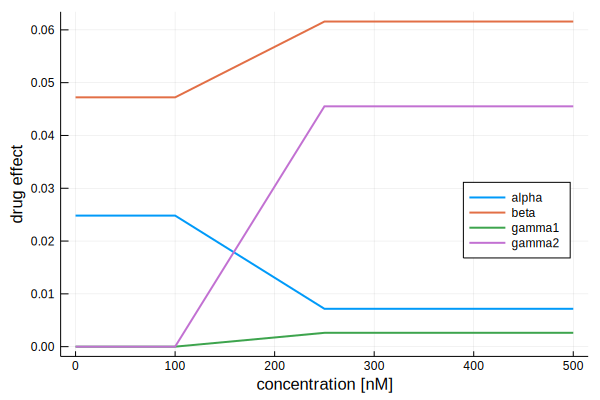

In [3]:
using Plots;
p = getDDEparams(pp, conc)
plot(conc, p[1, :], label = "alpha", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[2, :], label = "beta", linewidth = 2, legend =:right)
plot!(conc, p[5, :], label = "gamma1", linewidth = 2)
plot!(conc, p[6, :], label = "gamma2", linewidth = 2)


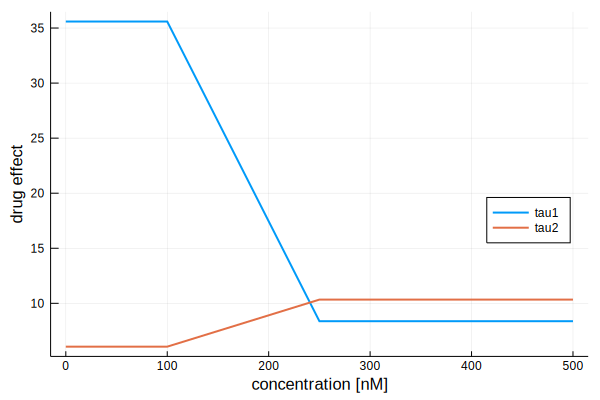

In [4]:
plot(conc, p[3, :], label = "tau1", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[4, :], label = "tau2", linewidth = 2, legend =:right)

### Plot the data with the new set of parameters for DDE

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::DataFrame, ::Int64, ::String) at plot.jl:32
└ @ Main /home/farnazm/dde/improve_fit/DrugResponseModel.jl/src/plot.jl:32


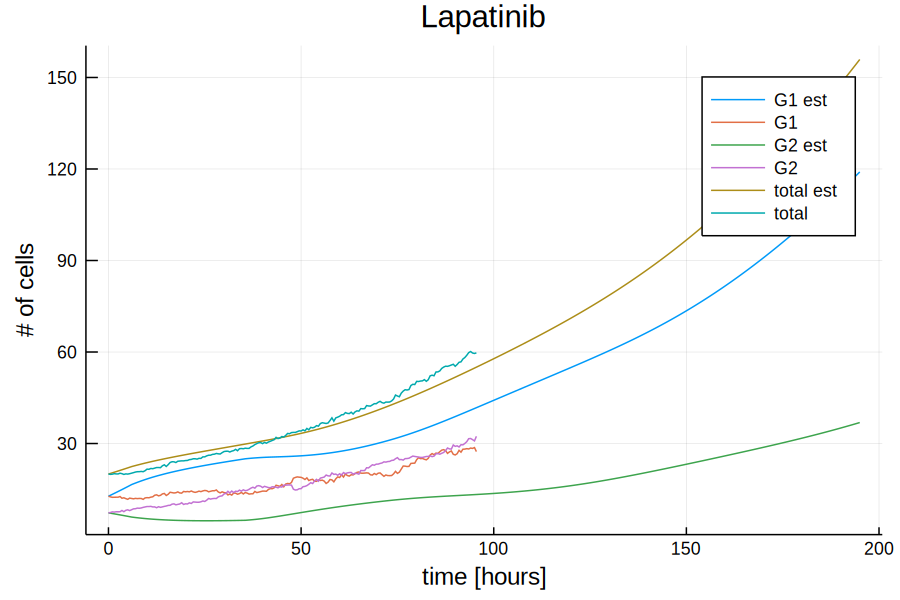

In [5]:
j = 2 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib")